__Author:__ Bram Van de Sande

__Date:__ 31 JAN 2018

__Outline:__ Derive potential regulomes from these co-expression modules.

The first method to create the TF-modules is to select the best targets for each transcription factor:
1. Targets with weight > 0.001
1. Targets with weight > 0.005

The second method is to select the top targets for a given TF:
1. Top 50 targets (targets with highest weight)

The alternative way to create the TF-modules is to select the best regulators for each gene (this is actually how GENIE3 internally works). Then, these targets can be assigned back to each TF to form the TF-modules. In this way we will create three more gene-sets:
1. Targets for which the TF is within its top 5 regulators
1. Targets for which the TF is within its top 10 regulators
1. Targets for which the TF is within its top 50 regulators

In [1]:
import os
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

from functools import partial

from pyscenic.genesig import Regulome
from pyscenic.utils import modules_from_genie3

In [2]:
%matplotlib inline

In [3]:
RESOURCES_FOLDER="/Users/bramvandesande/Projects/lcb/resources"
DATA_FOLDER="/Users/bramvandesande/Projects/lcb/tmp"

In [4]:
adjacencies = pd.read_csv(os.path.join(DATA_FOLDER, "coexpression-modules.tsv"), sep='\t')

In [5]:
adjacencies.head()

,TF,target,importance
0,Rpl7,Rpl34-ps1,86.119870
1,Olig1,Cnp,70.127927
2,Olig1,Tspan2,69.595029
3,Neurod6,Hpca,68.236759
4,Olig1,Cers2,67.195168


In [6]:
len(adjacencies)

4109019

In [7]:
len(adjacencies.TF.unique())

858

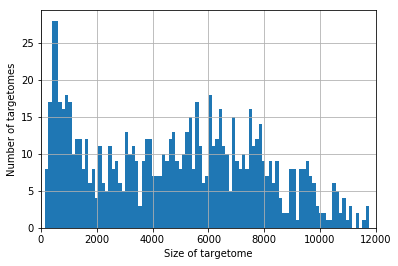

In [8]:
adjacencies.TF.value_counts().hist(bins=100)
plt.xlim([0,12000])
plt.xlabel("Size of targetome")
plt.ylabel("Number of targetomes");

Relationship between TF and its target, i.e. activator or repressor, is derived using the original expression profiles. The Pearson product-moment correlation coefficient is used to derive this information.

In [9]:
fname = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")
ex_mtx = pd.read_csv(fname, sep='\t', header=0, index_col=0)

In [10]:
# Remove duplicate genes ...
ex_mtx = ex_mtx[~ex_mtx.index.duplicated(keep='first')]

In [11]:
corr_mtx = pd.DataFrame(index=ex_mtx.index, columns=ex_mtx.index, data=np.corrcoef(ex_mtx.values))

In [12]:
def add_regulation(row, corr_mtx):
    tf = row['TF']
    target = row['target']
    rho = corr_mtx[tf][target]
    return int(rho > 0.03) - int(rho < 0.03)

In [13]:
adjacencies['correlation'] = adjacencies.apply(partial(add_regulation, corr_mtx=corr_mtx), axis=1)

We will keep only the TF-target links that have a postive correlation.

In [14]:
len(adjacencies[adjacencies['correlation'] > 0.0])

3144550

In [15]:
modules = list(modules_from_genie3(adjacencies[adjacencies['correlation'] > 0.0], "MGI"))

In [16]:
len(modules)

5148

In [17]:
len(modules)

5148

Remove modules that are less than 20 genes.

In [18]:
modules = list(filter(lambda m: len(m) >= 20, modules))

In [19]:
len(modules)

5106

In [20]:
with open(os.path.join(DATA_FOLDER, 'modules.pickle'), 'wb') as f:
    pickle.dump(modules, f, pickle.HIGHEST_PROTOCOL)